# Songs Popularity Prediction

## Obiettivo 
L'obiettivo di questo progetto è la creazione di un modello in grado di predire la popolarità **attuale** di una canzone sulla base di alcuni suoi parametri, quali il genere, la durata e l'anno di uscita. 

## Dataset
L'idea per questo progetto è nata da un dataset trovato su Kaggle all'indirizzo https://www.kaggle.com/datasets/conorvaneden/best-songs-on-spotify-for-every-year-2000-2023, il quale contiene dati sulle 100 canzoni più popolari per ogni anno dal 2000 al 2023, per un totale di 2385 record.

## Implementazione

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Creazione dataset

Leggiamo il dataset dal file csv scaricato manualmente da Kaggle, e ne mostriamo le prime righe.

In [2]:
songs = pd.read_csv("kaggle_songs.csv", sep=";")
songs.head(10)

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,-8,25,86,131,25,5,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,-6,8,17,222,42,5,96
5,Daylight,David Kushner,gen z singer-songwriter,2023,130,43,51,-9,9,32,213,83,3,96
6,TQG,KAROL G,reggaeton,2023,180,63,72,-4,9,61,199,67,28,96
7,Calm Down (with Selena Gomez),Rema,afrobeats,2022,107,81,80,-5,11,80,239,38,4,95
8,Anti-Hero,Taylor Swift,pop,2022,97,64,64,-7,14,53,201,13,5,94
9,Here With Me,d4vd,bedroom pop,2022,132,47,57,-8,13,29,242,53,3,94


Si osservi che i record del dataset sono già ordinati per valori di popolarità decrescente.

Notare inoltre come sia stato usato un indice numerico generato automaticamente da pandas, poiché nessun insieme di attributi può costituire una chiave primaria in questo dataset: il titolo non può esserlo perché due canzoni diverse possono ovviamente condividere lo stesso titolo, ma anche la coppia (titolo, artista) non funziona in quanto una canzone può essere rilasciata più volte (in linea teorica anche durante lo stesso anno, per quanto molto improbabile).

Questa è la descrizione del significato delle variabili data dal sito http://organizeyourmusic.playlistmachinery.com/ utilizzato dal creatore del dataset:
- Genre - the genre of the track
- Year - the release year of the recording. Note that due to vagaries of releases, re-releases, re-issues and general madness, sometimes the release years are not what you'd expect.
- Beats Per Minute (BPM) - The tempo of the song.
- Energy - The energy of a song - the higher the value, the more energetic the song is.
- Danceability - The higher the value, the easier it is to dance to this song.
- Loudness (dB) - The higher the value, the louder the song.
- Liveness - The higher the value, the more likely the song is a live recording.
- Valence - The higher the value, the more positive mood for the song.
- Acousticness - The higher the value the more acoustic the song is.
- Speechiness - The higher the value the more spoken word the song contains.
- Popularity - The higher the value the more popular the song *currently* is.
- Duration - The length of the song.

Tutte le feature numeriche fatta eccezione per la durata, l'anno, i BPM e i decibel hanno come dominio il range di valori 0-100.

La definizione di alcune feature, come _energy_, _danceability_, _valence_ e _popularity_, appare piuttosto vaga e soggettiva. In assenza di dettagli riguardo all'algoritmo utilizzato per calcolarle, sarà necessario considerarne i valori per avere un'idea più precisa del loro significato.

Nel nome delle colonne *speechiness* e *danceability* è presente uno spazio di troppo, che va rimosso.

In [3]:
songs.columns = songs.columns.str.replace('speechiness ', 'speechiness').str.replace('danceability ', 'danceability')

Aggiungiamo ora altre canzoni reperite da alcune playlist generate dall'app di Spotify. 

Si è ritenuto necessario incorporare altri brani sia perché la quantità contenuta nel dataset iniziale è subito apparsa piuttosto scarsa per il task in questione, ma anche perché le canzoni che compaiono in tale dataset sono tutt'altro che casuali, essendo state scelte proprio in base alla loro popolarità. Si tratta di un *bias* implicito nei dati molto forte, che probabilmente avrebbe reso difficile la creazione di modelli di predizione ragionevolmente accurati. In altre parole, questa operazione serve prevalentemente ad aggiungere canzoni poco o mediamente popolari. 

La scelta delle playlist da integrare è stata fatta cercando di mantenere una certa varietà di generi e artisti, ma anche una qualche consistenza temporale, preferendo canzoni recenti (pubblicate dopo il 2000) rispetto ad altre più vecchie.

I dati sono stati prelevati dal sito Organize Your Music (lo stesso usato dal creatore del dataset di Kaggle) tramite un plugin in grado di leggere tabelle in formato HTML e trasformarle in file csv. Questi file risultano un po' "sporchi", quindi serve qualche operazione di pulizia del nuovo dataset prima di integrarlo nel precedente.

In [4]:
naughts = pd.read_csv("2000s.csv", sep=",")
tens = pd.read_csv("2010s.csv", sep=",")
twenties = pd.read_csv("2020s.csv", sep=",")
now = pd.read_csv("now.csv", sep=",")

new_songs = pd.concat([naughts, tens, twenties, now])

Vengono escluse le canzoni del genere *uk drill* poiché, forse per un errore nell'API di Spotify, quasi tutte le loro popolarità sono 0 (cioè il valore minimo). Inoltre, vengono rimosse anche tutte quelle canzoni che hanno valori nulli nella colonna *genre*.

In [5]:
new_songs.drop(labels=["Unnamed: 0", "sel", "Unnamed: 2", "added"], axis=1, inplace=True)
new_songs.columns = songs.columns
new_songs = new_songs[new_songs["top genre"] != "uk drill"].copy()
new_songs.dropna(axis=0, how="any", inplace=True)

Modifichiamo tutte le feature numeriche affinché contengano valori interi invece di float o stringhe (l'unica variabile che viene interpretata come stringa dal parser csv è *duration*):

In [6]:
new_songs["bpm"] = new_songs["bpm"].map(lambda elem: int(elem))
new_songs["energy"] = new_songs["energy"].map(lambda elem: int(elem))
new_songs["danceability"] = new_songs["danceability"].map(lambda elem: int(elem))
new_songs["dB"] = new_songs["dB"].map(lambda elem: int(elem))
new_songs["liveness"] = new_songs["liveness"].map(lambda elem: int(elem))
new_songs["valence"] = new_songs["valence"].map(lambda elem: int(elem))
new_songs["acousticness"] = new_songs["acousticness"].map(lambda elem: int(elem))
new_songs["speechiness"] = new_songs["speechiness"].map(lambda elem: int(elem))

In [7]:
new_songs["duration"] = new_songs["duration"].map(lambda duration: int(duration.replace(",", "")) 
                                                  if type(duration) is not int else duration)

In [8]:
new_songs

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Yellow,Coldplay,permanent wave,2000,173,66,43,-7,23,28,267,0,3,93
1,Without Me,Eminem,detroit hip hop,2002,112,67,91,-3,24,66,290,0,7,91
2,The Real Slim Shady,Eminem,detroit hip hop,2000,105,66,95,-4,5,76,284,3,6,90
3,In the End,Linkin Park,alternative metal,2000,105,86,56,-6,21,40,217,1,6,89
4,The Scientist,Coldplay,permanent wave,2002,146,44,56,-7,11,21,310,73,2,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2292,La Vecinita,Vico C,latin hip hop,2018,94,64,93,-6,6,85,266,8,26,0
2295,Yo Te Pidere',Los Reyes,northern irish punk,2018,118,89,64,-7,5,73,182,15,4,0
2304,Rumba Habana,DJ Sanny J,italo dance,2018,127,87,82,-5,6,77,396,2,12,0
2311,El Doctorado - Remix,Tony Dize,reggaeton,2019,120,71,74,-7,29,74,265,15,5,0


A questo punto possiamo concatenare insieme i due dataset, ottenendo il dataset principale che useremo durante tutto lo sviluppo.

In [9]:
songs = pd.concat([songs, new_songs], ignore_index=True)
songs

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,-8,25,86,131,25,5,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,-6,8,17,222,42,5,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11447,La Vecinita,Vico C,latin hip hop,2018,94,64,93,-6,6,85,266,8,26,0
11448,Yo Te Pidere',Los Reyes,northern irish punk,2018,118,89,64,-7,5,73,182,15,4,0
11449,Rumba Habana,DJ Sanny J,italo dance,2018,127,87,82,-5,6,77,396,2,12,0
11450,El Doctorado - Remix,Tony Dize,reggaeton,2019,120,71,74,-7,29,74,265,15,5,0


### Analisi esplorativa

Dividiamo le feature in testuali e numeriche.

In [10]:
string_columns = songs.select_dtypes(include=["object"]).columns
numeric_columns = songs.select_dtypes(include=["number"]).columns

In [11]:
print("String columns: ", list(string_columns))
print("Numeric columns: ", list(numeric_columns))

String columns:  ['title', 'artist', 'top genre']
Numeric columns:  ['year', 'bpm', 'energy', 'danceability', 'dB', 'liveness', 'valence', 'duration', 'acousticness', 'speechiness', 'popularity']


Con la funzione **describe** otteniamo una prima visualizzazione numerica della distribuzione dei dati all'interno del dataset.

In [12]:
songs.describe()

,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
count,11452.000000,11452.000000,11452.000000,11452.000000,11452.000000,11452.000000,11452.000000,11452.000000,11452.000000,11452.000000,11452.000000
mean,2013.118058,122.278030,70.844831,64.315753,-6.215246,18.630545,51.824048,230.488910,17.088194,10.979654,58.817848
std,6.541607,27.462165,18.268013,16.063173,2.691750,14.581849,23.390797,65.620088,22.520569,10.699883,18.508337
min,1985.000000,52.000000,4.000000,9.000000,-25.000000,1.000000,3.000000,30.000000,0.000000,2.000000,0.000000
25%,2008.000000,100.000000,59.000000,54.000000,-7.000000,9.000000,34.000000,193.000000,1.000000,4.000000,48.000000
50%,2015.000000,123.000000,73.000000,66.000000,-6.000000,13.000000,52.000000,221.000000,7.000000,6.000000,62.000000
75%,2018.000000,139.000000,85.000000,76.000000,-4.000000,24.000000,70.000000,254.000000,25.000000,13.000000,73.000000
max,2023.000000,236.000000,100.000000,99.000000,0.000000,97.000000,98.000000,1904.000000,99.000000,88.000000,98.000000


Notiamo come l'anno di pubblicazione meno recente sia il 1985. Non si tratta necessariamente di un errore nei dati, in quanto il dataset scaricato da Kaggle contiene le canzoni più _popolari_ per ogni anno dal 2000 al 2023, ma chiaramente la data di uscita delle canzoni non è limitata a questo periodo. 

Tuttavia, si è comunque deciso di rimuovere dal dataset tutte le canzoni precedenti all'anno 2000, in quanto questa limitazione temporale permette di evitare che la feature *year* sia troppo rilevante nella predizione, per il semplice fatto che una canzone recente è più probabile che sia ancora popolare rispetto ad una canzone uscita molti anni fa. Queste canzoni sono in ogni caso pochissime (solo 47).

In [13]:
songs = songs[songs["year"] >= 2000]
songs = songs.reset_index(drop=True)
songs

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,-8,25,86,131,25,5,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,-6,8,17,222,42,5,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11400,La Vecinita,Vico C,latin hip hop,2018,94,64,93,-6,6,85,266,8,26,0
11401,Yo Te Pidere',Los Reyes,northern irish punk,2018,118,89,64,-7,5,73,182,15,4,0
11402,Rumba Habana,DJ Sanny J,italo dance,2018,127,87,82,-5,6,77,396,2,12,0
11403,El Doctorado - Remix,Tony Dize,reggaeton,2019,120,71,74,-7,29,74,265,15,5,0


Andiamo ora più nel dettaglio e vediamo se esiste qualche correlazione rilevante tra le feature. La funzione **scatter_matrix** permette di ottenere una matrice nella quale ogni cella non diagonale contiene uno *scatter plot* di due feature (numeriche) del dataset. Nelle celle diagonali vengono invece mostrati gli istogrammi dei valori delle feature.

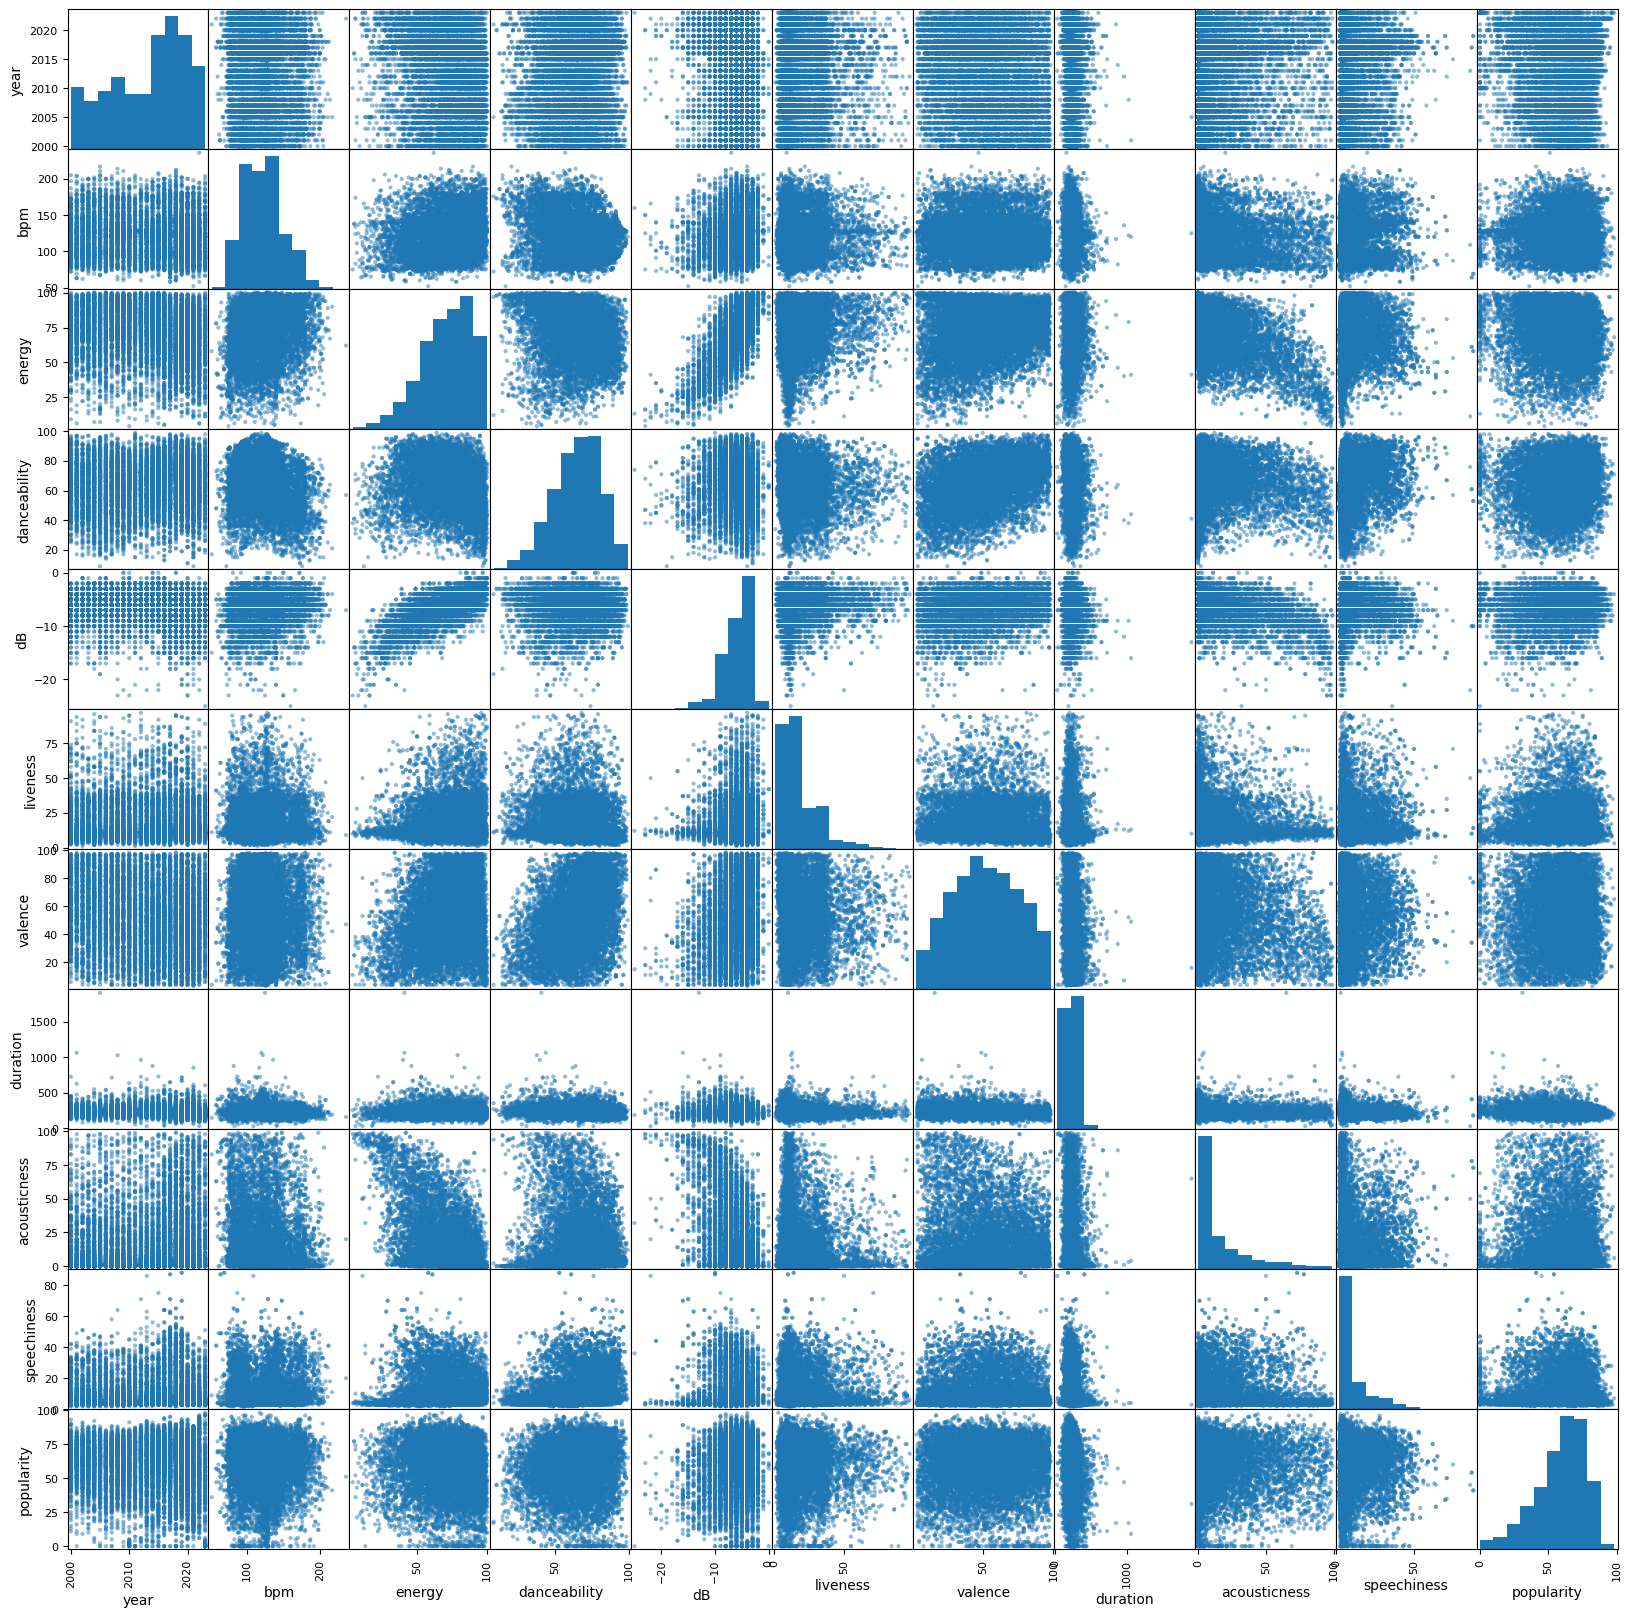

In [14]:
from pandas.plotting import scatter_matrix

scatter_matrix(songs[numeric_columns], figsize=(20, 20));

Osserviamo come non ci siano forti correlazioni tra la popolarità attuale e una qualche altra feature.


Alcune correlazioni molto forti sono quelle tra "energia" e intensità di volume in *dB* (positiva) e tra "energia" e *acousticness* (negativa), entrambe abbastanza ovvie.

Siccome molte correlazioni nel grafico precedente non appaiono chiare, utilizziamo la funzione **corr** dei DataFrame di pandas per creare una tabella a doppia entrata che mostri a livello numerico la correlazione tra una feature e ciascuna delle altre, secondo il *coefficiente di Pearson*.

<Figure size 2000x2000 with 0 Axes>

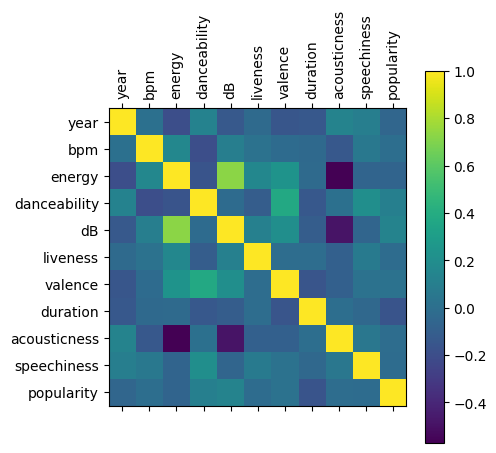

In [15]:
corr = songs.corr(numeric_only=True, method="pearson")
plt.figure(figsize=(20, 20))
plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

Sorprendentemente, la popolarità di una canzone non sembra particolarmente correlata con nessuna delle caratteristiche intrinseche della canzone stessa, come ad esempio la sua energià, danzabilità e durata.

Ad ulteriore riprova, mostriamo la correlazione delle feature numeriche con la variabile _popularity_.

In [16]:
corr = songs[numeric_columns].corr()
corr["popularity"].sort_values(ascending=False)

popularity      1.000000
dB              0.131546
danceability    0.103752
valence         0.018634
bpm            -0.002545
acousticness   -0.011698
liveness       -0.013539
speechiness    -0.016424
year           -0.054291
energy         -0.068000
duration       -0.160724
Name: popularity, dtype: float64

Infine, vediamo la distribuzione di generi e artisti.

In [17]:
songs["top genre"].value_counts()

dance pop             819
alternative metal     529
atl hip hop           389
pop                   367
alternative rock      319
                     ... 
dutch metal             1
post-teen pop           1
swedish americana       1
progressive sludge      1
french hip hop          1
Name: top genre, Length: 798, dtype: int64

In [18]:
(songs["top genre"].value_counts() == 1).sum() / songs["top genre"].value_counts().count()

0.2706766917293233

I generi sono estremamente specifici, in quanto ci sono caratterizzazioni regionali all'interno di ciascun genere. Addirittura, il 27% di tutti i generi presenti nel dataset compare con una sola canzone.

In [19]:
songs["artist"].value_counts()

Kendrick Lamar      90
Kanye West          82
Drake               71
Calvin Harris       61
Rihanna             52
                    ..
John O'Callaghan     1
Ian van Dahl         1
Valentino Khan       1
Jauz                 1
Booba                1
Name: artist, Length: 3274, dtype: int64

In [20]:
songs["artist"].count() / songs["artist"].value_counts().count()

3.4835064141722665

Anche gli artisti sono molti rispetto al numero di canzoni totali. Mediamente, ogni artista è presente con circa 3.5 canzoni all'interno del dataset.

### Integrazione del dataset con altre fonti

#### NLP

Si è ritenuto necessario considerare per ogni canzone anche il suo testo, il cui contenuto, opportunamente processato con tecniche di Natural Language Processing, può essere di aiuto per predirne la popolarità.
Abbiamo dunque fatto uso della libreria *lyricsgenius*, che tramite l'API del sito https://genius.com/ permette di scaricare il testo di una canzone dato il titolo e l'autore.

Per motivi di semplicità, la parte di Natural Language Processing viene svolta solo sulle canzoni presenti nel dataset scaricato da Kaggle, e non sulle altre canzoni introdotte via playlist.

Di seguito è possibile trovare il codice (commentato) che implementa questa operazione. Si noti tuttavia che l'esecuzione richede molto tempo (almeno un'ora), in quanto le richieste vanno spesso in timeout. Non è comunque necessario eseguire le celle seguenti, infatti i testi sono già stati scaricati e si trovano nel file *songs_lyrics.csv*. 

In [21]:
# %pip install lyricsgenius
# import lyricsgenius as lg

In [22]:
import csv

"""
access_token = '8yvpmDv96aodI5vg660Afcby4XPdrhPrx4JCAM3souNcRYG9C2nF5TWg1'
genius = lg.Genius(access_token)

def get_lyrics(song_title, artist_name):
    song = genius.search_song(song_title, artist_name)
    return song.lyrics if song is not None else ""

songs = pd.read_csv("songs.csv", sep=";")

with open("songs_lyrics.csv", "a", newline="", encoding="utf-8") as csv_file:
    writer = csv.writer(csv_file, delimiter="|")
    writer.writerow(["title", "artist", "lyrics"])
    for _, song in songs.iterrows():
        is_ok = False
        while not is_ok:
            try:
                lyrics = get_lyrics(song.title, song.artist)
                is_ok = True
                writer.writerow([song.title, song.artist, lyrics])
            except Exception as e:
                continue
""";

Carichiamo e mostriamo il nuovo dataset contenente le _lyrics_ delle canzoni.

In [23]:
songs_lyrics = pd.read_csv("songs_lyrics.csv", sep="|", na_values={"": None}, keep_default_na=False)
songs_lyrics

,title,artist,lyrics
0,Flowers,Miley Cyrus,88 ContributorsTranslationsEspañolPortuguêsKis...
1,Cupid - Twin Ver.,FIFTY FIFTY,1 ContributorTranslationsEnglishBahasa MelayuF...
2,BESO,ROSALÍA,29 ContributorsTranslationsPortuguêsEnglishDeu...
3,Boy's a liar Pt. 2,PinkPantheress,92 ContributorsTranslationsPortuguêsTürkçeDeut...
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,2 ContributorsNew Music Friday 12/02/22 Lyrics...
...,...,...,...
2380,Southbound,Beach Blvd,2 ContributorsMe & My Skate Lyrics[Skit]\r\nOh...
2381,Dance with Somebody - Radio Version,Mando Diao,1 ContributorDance With Somebody - Radio Versi...
2382,Flow,Desire Machines,1 ContributorWhat Matters? Lyrics[Hook]\r\nLea...
2383,Scared of the Dark,Everything Brighter,1 ContributorWay Home LyricsYa Ya Ya\r\n\r\nI ...


Per alcune canzoni, l'API di Genius non fornisce alcun testo.

In [24]:
print(f"Ci sono {(songs_lyrics['lyrics'] == '').sum()} canzoni di cui non è stato trovato il testo.")
songs_lyrics[songs_lyrics["lyrics"] == ''].head(10)

Ci sono 54 canzoni di cui non è stato trovato il testo.


,title,artist,lyrics
16,Until I Found You (with Em Beihold) - Em Beiho...,Stephen Sanchez,
317,"Happy - From ""Despicable Me 2""",Pharrell Williams,
339,"Moves Like Jagger - Studio Recording From ""The...",Maroon 5,
446,CAN'T STOP THE FEELING! (from DreamWorks Anima...,Justin Timberlake,
684,Valerie (feat. Amy Winehouse) - Version Revisited,Mark Ronson,
686,Waka Waka (This Time for Africa) [The Official...,Shakira,
905,Free Fallin' - Live at the Nokia Theatre Los A...,John Mayer,
912,Intro,The xx,
947,Summertime Sadness (Lana Del Rey Vs. Cedric Ge...,Lana Del Rey,
1086,Jenny from the Block (feat. Jadakiss & Styles ...,Jennifer Lopez,


In generale, i testi scaricati sono "sporchi", cioè contengono messaggi da parte dell'API che però non fanno parte del testo della canzone. 

In [25]:
songs_lyrics["lyrics"][0]

"88 ContributorsTranslationsEspañolPortuguêsKiswahiliDeutschItalianoСрпскиNederlandsSvenskaPolskiTürkçeΕλληνικάFrançaisDanskРусскийالعربيةУкраїнськаBahasa IndonesiaFlowers Lyrics[Verse 1]\r\nWe were good, we were gold\r\nKinda dream that can't be sold\r\nWe were right 'til we weren't\r\nBuilt a home and watched it burn\r\n\r\n[Pre-Chorus]\r\nMm, I didn't wanna leave you, I didn't wanna lie\r\nStarted to cry, but then remembered I\r\n\r\n[Chorus]\r\nI can buy myself flowers\r\nWrite my name in the sand\r\nTalk to myself for hours\r\nSay things you don't understand\r\nI can take myself dancing\r\nAnd I can hold my own hand\r\nYeah, I can love me better than you can\r\n\r\n[Post-Chorus]\r\nCan love me better, I can love me better, baby\r\nCan love me better, I can love me better, baby\r\n\r\n[Verse 2]\r\nPaint my nails cherry-red\r\nMatch the roses that you left\r\nNo remorse, no regret\r\nI forgive every word you said\r\nYou might also like[Pre-Chorus]\r\nOoh, I didn't wanna leave you, b

Molti dei testi che hanno pochi "contributors" (meno di 20) sono sbagliati: la seguente funzione permette di rimuoverli, cioè di assegnare ad essi il valore stringa vuota (''). Inoltre, rimuove dai testi validi le parti di stringa che non corrispondono al reale testo della canzone. 

In [26]:
def clean_lyrics(text):
    if text != '':
        contributors, other = text.split("Contributor")
        text = other.split("Lyrics")[1].split("Embed")[0] if int(contributors) > 20 else ''
    return text

In [27]:
songs_lyrics["lyrics"] = songs_lyrics["lyrics"].map(clean_lyrics)

In [28]:
print(f"Ci sono {(songs_lyrics['lyrics'] == '').sum()} canzoni di cui non è stato trovato il testo.")
songs_lyrics[songs_lyrics["lyrics"] == ''].head(10)

Ci sono 775 canzoni di cui non è stato trovato il testo.


,title,artist,lyrics
1,Cupid - Twin Ver.,FIFTY FIFTY,
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,
7,Calm Down (with Selena Gomez),Rema,
12,Die For You - Remix,The Weeknd,
16,Until I Found You (with Em Beihold) - Em Beiho...,Stephen Sanchez,
29,Unholy (feat. Kim Petras),Sam Smith,
36,La Bachata,Manuel Turizo,
38,lovely (with Khalid),Billie Eilish,
46,Yandel 150,Yandel,
50,Double Fantasy (with Future),The Weeknd,


Il numero di canzoni che non possiedono testo è aumentato significativamente. Purtroppo questo problema è dovuto alle risposte fornite dall'API di Genius, quindi non è risolvibile a meno di non utilizzare un'altra API.

A questo punto il dataset è pronto per essere processato. Importiamo quindi le librerie necessarie per il NLP.

In [29]:
%pip install nltk
import nltk

%pip install langdetect
from langdetect import detect

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Per prima cosa, aggiungiamo al DataFrame una colonna contenente la lingua in cui è cantata la canzone, utilizzando la funzione **detect** del package **langdetect**.

In [30]:
def detect_language(text):
    return detect(text) if text != '' else None

In [31]:
songs_lyrics["language"] = songs_lyrics["lyrics"].map(detect_language)
songs_lyrics

,title,artist,lyrics,language
0,Flowers,Miley Cyrus,"[Verse 1]\r\nWe were good, we were gold\r\nKin...",en
1,Cupid - Twin Ver.,FIFTY FIFTY,,None
2,BESO,ROSALÍA,"[Letra de ""BESO""]\r\n\r\n[Coro: ROSALÍA]\r\nYa...",es
3,Boy's a liar Pt. 2,PinkPantheress,[Verse 1: PinkPantheress]\r\nTake a look insid...,en
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,,None
...,...,...,...,...
2380,Southbound,Beach Blvd,,None
2381,Dance with Somebody - Radio Version,Mando Diao,,None
2382,Flow,Desire Machines,,None
2383,Scared of the Dark,Everything Brighter,,None


Notare come le canzoni senza testo o il cui testo è stato precedentemente scartato a causa dei pochi "contributors" abbiano il valore **None** nella colonna **language**.

La distribuzione dei valori mostra come la stragrande maggioranza delle canzoni che possiedono un testo "valido" siano in lingua inglese. Questo è presumibilmente dovuto al fatto che Genius è un sito americano e quindi fruito prevalentemente da anglofoni.

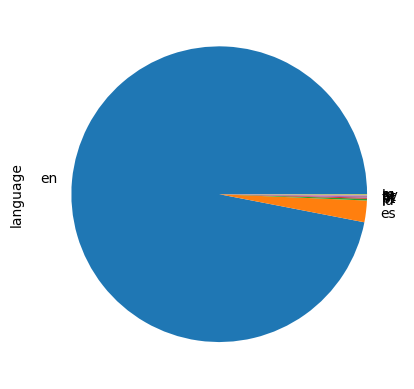

In [32]:
songs_lyrics["language"].value_counts().plot.pie();

Aggiungiamo al dataset la colonna _popularity_ presa dal dataset principale.

In [33]:
songs_lyrics["popularity"] = songs["popularity"]
songs_lyrics

,title,artist,lyrics,language,popularity
0,Flowers,Miley Cyrus,"[Verse 1]\r\nWe were good, we were gold\r\nKin...",en,98
1,Cupid - Twin Ver.,FIFTY FIFTY,,None,97
2,BESO,ROSALÍA,"[Letra de ""BESO""]\r\n\r\n[Coro: ROSALÍA]\r\nYa...",es,96
3,Boy's a liar Pt. 2,PinkPantheress,[Verse 1: PinkPantheress]\r\nTake a look insid...,en,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,,None,96
...,...,...,...,...,...
2380,Southbound,Beach Blvd,,None,84
2381,Dance with Somebody - Radio Version,Mando Diao,,None,84
2382,Flow,Desire Machines,,None,84
2383,Scared of the Dark,Everything Brighter,,None,84


Creiamo ora un dataset che contenga solo le canzoni con testo valido, da usare nell'addestramento e nella validazione di modelli predittivi che facciano uso di tecniche di NLP.

In [34]:
valid_songs_lyrics = songs_lyrics[songs_lyrics["lyrics"] != '']
valid_songs_lyrics

,title,artist,lyrics,language,popularity
0,Flowers,Miley Cyrus,"[Verse 1]\r\nWe were good, we were gold\r\nKin...",en,98
2,BESO,ROSALÍA,"[Letra de ""BESO""]\r\n\r\n[Coro: ROSALÍA]\r\nYa...",es,96
3,Boy's a liar Pt. 2,PinkPantheress,[Verse 1: PinkPantheress]\r\nTake a look insid...,en,96
5,Daylight,David Kushner,[Verse 1]\r\nTelling myself I won't go there\r...,en,96
6,TQG,KAROL G,"[Letra de ""TQG""]\r\n\r\n[Intro: KAROL G]\r\nLa...",es,96
...,...,...,...,...,...
2349,Lips Of An Angel,Hinder,"[Verse 1]\r\nHoney, why you callin’ me so late...",en,88
2351,Fake It,Seether,[Verse 1]\r\nWho's to know if your soul will f...,en,87
2355,Switch,Will Smith,"[Intro]\r\nYo mic check, mic check, yeah here ...",en,86
2361,The Selfish Gene,Marlon Percy,"5/1\r\n11:11 - ""Me, Chanel & Jameson""\r\nAazar...",en,85


Costruiamo un semplice modello di tipo Bag of Words, così da avere una prima idea approssimativa di quanto la presenza di parole ricorrenti all'interno del testo di una canzone ne influenzi la popolarità. Facendo uso di un'istanza di **CountVectorizer**, possiamo creare una matrice testi-parole, nella quale ogni riga rappresenta una canzone e ogni colonna una parola che compare in almeno 15 canzoni. Questa soglia minima è stata aggiunta così da ridurre la dimensionalità dello spazio vettoriale. Inoltre, vengono anche rimosse le cosiddette _stopwords_ dai testi in lingua inglese.

Sulla matrice così creata viene effettuata una somma sulle colonne, il cui risultato è un vettore che associa ad ogni canzone la quantità di parole comuni che compaiono nel suo testo.

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

cvect = CountVectorizer(min_df=15, stop_words="english")
mat = cvect.fit_transform(valid_songs_lyrics["lyrics"])
lyric_popularity = mat.toarray().sum(axis=1)

In [36]:
np.corrcoef(lyric_popularity, valid_songs_lyrics["popularity"])

array([[ 1.        , -0.15209792],
       [-0.15209792,  1.        ]])

Questo risultato mostra come sia presente una leggera correlazione negativa tra il vettore contenente le "popolarità dei testi" e quello contenente i valori di popolarità delle canzoni. Si tratta di un risultato certamente interessante, ma sarebbe sbagliato trarre la conclusione che un testo "banale" implica una minor popolarità della canzone.

In effetti, si è scelto di non includere per nulla questa feature nel dataset principale, sia perché i suoi valori dipendono fortemente da quali canzoni fanno parte del dataset in uso, sia per la difficoltà di gestire le canzoni che non hanno testo.

Si è quindi deciso di provare a cercare un insieme di termini _significativi_, ovvero parole la cui presenza influenzi positivamente o negativamente la popolarità della canzone. Per fare ciò, si è fatto uso di un modello di regressione con regolarizzazione **LASSO**, in modo tale che l'insieme di parole desiderato sia dato da tutte le parole il cui coefficiente all'interno del modello sia diverso da 0.  

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(valid_songs_lyrics["lyrics"], valid_songs_lyrics["popularity"], 
                                                    test_size=1/3, random_state=42)

In [86]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def print_eval(model, X, y_true):
    y_pred = model.predict(X)
    print(f"R2: {r2_score(y_true, y_pred):.3f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred, squared=True)):.3f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.3f}")

Questa funzione crea un dizionario che associa ad ogni parola il suo coefficiente nel modello, a patto che esso sia superiore ad una data soglia.

In [39]:
def create_features_dict(model, threshold):
    features = model["vect"].get_feature_names_out()
    # Valid words is the number of words included in the vector space.
    print("Valid words:", len(features))
    coefs = model["regr"].coef_
    features_coefs = {features[i]: coefs[i] for i in range(len(features)) if abs(coefs[i]) > threshold}
    # Valuable words is the number of words whose coefficient is greater than a given threshold.
    print("Valuable words:", len(features_coefs))
    return features_coefs

Definiamo il modello e testiamolo con un valore di **alpha** basso. 

Ciascuna istanza di modello testata fa uso di un **CountVectorizer** che ignora le _stopword_ inglesi. Inoltre, si è preferito non dichiarare nessun valore per *min_df*, poiché esso avrebbe introdotto un bias implicito dovuto alla maggior presenza di testi inglesi nel dataset.

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

model = Pipeline([
    ("vect", CountVectorizer(stop_words="english")),
    ("regr", Lasso(alpha=0.1))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)
features_coefs = create_features_dict(model, threshold=0.01)
features_coefs, model["regr"].intercept_

R2: -0.220
RMSE: 10.994
MAE: 8.251
MAPE: 12.517%
Valid words: 16917
Valuable words: 449


({'10': -0.3813838170027861,
  '21': 0.3673036215999154,
  'aah': -0.17754814139057612,
  'adios': -0.7770046184900194,
  'ah': 0.10019651827710863,
  'ain': -0.23621544402542474,
  'alarm': -0.14958359875549326,
  'angel': 0.4232905521434098,
  'apart': -0.21174549747749533,
  'ask': -0.47035323396141915,
  'aw': 0.07219648953616413,
  'ay': -0.18612690612533328,
  'ayy': 0.018834877245500134,
  'ayyy': 0.043006163001722296,
  'babe': 0.14199379809492882,
  'bad': -0.18289142354286167,
  'badoom': 0.1315706161893652,
  'bag': -0.1531758517634695,
  'bah': -0.23987490671680547,
  'bailando': -0.06268702993766277,
  'ball': 0.16517275520050315,
  'ballin': -0.15254717483783325,
  'balvin': -0.012442251225913583,
  'bang': 0.0754081372944673,
  'beat': -0.08152731446661075,
  'beep': -0.16300351424489748,
  'beggin': 0.07562577198386648,
  'believe': -0.041946085579059524,
  'belong': -0.07393967491730773,
  'bennington': 0.3190957925306694,
  'best': -0.14259804448204408,
  'better': 0.

Ovviamente, se **alpha** è prossimo a 0 (come nel modello soprastante) le parole considerate significative dal modello saranno tante. 

Proviamo un valore di **alpha** maggiore.

In [41]:
model = Pipeline([
    ("vect", CountVectorizer(stop_words="english")),
    ("regr", Lasso(alpha=1))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)
features_coefs = create_features_dict(model, threshold=0.01)
features_coefs, model["regr"].intercept_

R2: 0.029
RMSE: 9.810
MAE: 7.622
MAPE: 11.690%
Valid words: 16917
Valuable words: 33


({'10': -0.17745691666808372,
  'ah': 0.08554401938951074,
  'ain': -0.12289385424597718,
  'bah': -0.10674907506826714,
  'bitch': -0.01669495746663426,
  'chorus': 0.023372922925235236,
  'don': -0.10095845432588989,
  'doo': -0.09477469131747789,
  'faded': -0.1308952921558031,
  'feel': 0.039657849251752954,
  'fly': -0.08142706973953316,
  'ft': 0.027680353653907502,
  'girl': -0.08355626483092334,
  'got': -0.06969933968376997,
  'ha': 0.05404947450662752,
  'hey': -0.04769457252843092,
  'hold': -0.15202708754451594,
  'hot': -0.01236110925864328,
  'know': -0.08855348596727639,
  'low': -0.05380149076140928,
  'make': -0.12015783910556399,
  'man': -0.19707100895005786,
  'nigga': -0.11974224205687406,
  'oh': -0.015435250126025394,
  'ooh': 0.02579096263852435,
  'que': 0.24081871569212562,
  'right': -0.02007888461652252,
  'rock': -0.11517914539524193,
  'said': 0.047055451350601414,
  'thing': -0.15040906527060532,
  'throw': -0.11447555692847722,
  'wanna': -0.031327939251

Aumentando il parametro **alpha** da 0.01 a 1, le parole significative si riducono di più di 13 volte. Tuttavia, il risultato appare ancora poco soddisfacente, in quanto tali parole sembrano piuttosto casuali e i coefficienti sono molto piccoli. 

Proviamo ad aumentare ancora il valore di **alpha**.

In [42]:
model = Pipeline([
    ("vect", CountVectorizer(stop_words="english")),
    ("regr", Lasso(alpha=4))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)
features_coefs = create_features_dict(model, threshold=0.01)
features_coefs, model["regr"].intercept_

R2: 0.002
RMSE: 9.945
MAE: 7.854
MAPE: 12.000%
Valid words: 16917
Valuable words: 2


({'don': -0.06202184819764611, 'know': -0.03696746350298479}, 73.3592652360171)

Con **alpha=5**, si ottiene un modello che fa uso di sole due parole per predire la popolarità di una canzone, ovvero _don_ e _know_. 

Le metriche di accuratezza di questo modello, così come dei precedenti, non sono incoraggianti in quanto sembra evidente che non esista un gruppo di termini in grado di influenzare la popolarità di una canzone. Inoltre, le parole individuate dal modello sono assolutamente causuali e non rappresentative di uno stile musicale o di un significato particolare.

Per questi motivi, si è deciso di non aggiungere al dataset principale nessuna nuova feature che riguardi il testo di una canzone, cosa che tra l'altro avrebbe reso complessa la gestione delle canzoni che non hanno testo. 

Nota: Una fonte di miglioramento per questo progetto potrebbe essere l'utilizzo della lingua come feature predittiva della popolarità. Purtroppo, non abbiamo trovato alcuna API che fornisse un modo semplice di ottenere la lingua di una canzone dato il titolo e l'artista.

#### Popolarità artisti su Spotify

Abbiamo pensato di introdurre una nuova feature che rappresenti la popolarità di un'artista, dato che la popolarità di una canzone è intrinsecamente proporzionale alla popolarità dell'artista che la crea. Per coerenza con i dati presenti nel dataset, abbiamo scelto di utilizzare l'indice di popolarità di Spotify, che assegna ad ogni artista un valore tra 0 (sconosciuto) e 100 (massima popolarità).

Utilizziamo dunque la Web API fornita da Spotify, tramite una libreria Python apposita per l'interfacciamento con l'API.

Spotify Web API: https://developer.spotify.com/documentation/web-api

Libreria Spotipy: https://spotipy.readthedocs.io/en/2.22.1/#

In [43]:
%pip install spotipy
import spotipy as sp

Note: you may need to restart the kernel to use updated packages.


Il seguente codice permette di stabilire una connessione all'API e di creare un file csv che contenga le popolarità di tutti gli artisti del dataset principale. Un artista compare nel nuovo file tante volte quante sono le sue canzoni nel dataset.

Ovviamente, *client_id* e *client_secret* stati rimossi per motivi di privacy.

In [44]:
'''
client_id = ''
client_secret = ''

spotify = sp.Spotify(client_credentials_manager=sp.oauth2.SpotifyClientCredentials(client_id, client_secret))

def get_artist_popularity(artist_name):
    results = spotify.search(q='artist:' + artist_name, type='artist')
    items = results['artists']['items']
    return items[0]['popularity'] if len(items) > 0 else np.nan

with open("artist_popularity.csv", "a", newline="", encoding="utf-8") as csv_file:
    writer = csv.writer(csv_file, delimiter="|")
    writer.writerow(["artist", "popularity"])
    for _, song in songs.iterrows():
        is_ok = False
        while not is_ok:
            try:
                popularity = get_artist_popularity(song.artist)
                is_ok = True
                writer.writerow([song.artist, popularity])
            except Exception as e:
                continue
''';

Leggiamo poi il file csv creato e ne carichiamo i dati su un dataset, eliminando i duplicati e ordinando per popolarità.

In [45]:
artist_popularity = pd.read_csv("artist_popularity.csv", sep="|")
artist_popularity.drop_duplicates(subset="artist", inplace=True)
artist_popularity.reset_index(drop=True, inplace=True)
artist_popularity.sort_values(by="popularity", ascending=False, inplace=True)
artist_popularity.head(20)

,artist,popularity
8,Taylor Swift,100.0
18,Bad Bunny,96.0
12,The Weeknd,95.0
22,Drake,95.0
100,Lana Del Rey,91.0
4,Metro Boomin,91.0
145,Future,90.0
49,Kanye West,90.0
132,BTS,90.0
19,Eminem,90.0


Infine uniamo il dataset della popolarità degli artisti al dataset principale, rinominando la colonna *popularity* in *song popularity*.

Per un errore nell'API, alcuni artisti risultano senza popolarità: abbiamo deciso di rimuovere le loro canzoni dal dataset.

In [46]:
artist_popularity.rename(columns={"popularity": "artist popularity"}, inplace=True)
songs.rename(columns={"popularity": "song popularity"}, inplace=True)

In [47]:
songs = pd.merge(songs, artist_popularity, on="artist", how="left")
# After a left join some songs may not have an artist popularity
songs.dropna(axis=0, how="any", inplace=True)
songs["artist popularity"] = songs["artist popularity"].map(lambda elem: int(elem))
songs.reset_index(drop=True, inplace=True)
songs

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,song popularity,artist popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98,87
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97,80
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96,84
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,-8,25,86,131,25,5,96,79
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,-6,8,17,222,42,5,96,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11393,La Vecinita,Vico C,latin hip hop,2018,94,64,93,-6,6,85,266,8,26,0,63
11394,Yo Te Pidere',Los Reyes,northern irish punk,2018,118,89,64,-7,5,73,182,15,4,0,46
11395,Rumba Habana,DJ Sanny J,italo dance,2018,127,87,82,-5,6,77,396,2,12,0,27
11396,El Doctorado - Remix,Tony Dize,reggaeton,2019,120,71,74,-7,29,74,265,15,5,0,71


### Preparazione dataset

Dato che il dataset calcola la popolarità attuale, convertiamo l'anno di uscita nell'età della canzone rispetto all'anno corrente.

In [48]:
import datetime

current_year = datetime.date.today().year
songs["year"] = current_year - songs["year"]
songs.rename(columns={"year": "age"}, inplace=True)
songs

,title,artist,top genre,age,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,song popularity,artist popularity
0,Flowers,Miley Cyrus,pop,0,118,68,71,-4,3,65,200,6,7,98,87
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,0,120,59,78,-8,35,73,174,44,3,97,80
2,BESO,ROSALÍA,pop,0,95,64,77,-7,17,53,195,74,14,96,84
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,0,133,81,70,-8,25,86,131,25,5,96,79
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,1,98,62,72,-6,8,17,222,42,5,96,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11393,La Vecinita,Vico C,latin hip hop,5,94,64,93,-6,6,85,266,8,26,0,63
11394,Yo Te Pidere',Los Reyes,northern irish punk,5,118,89,64,-7,5,73,182,15,4,0,46
11395,Rumba Habana,DJ Sanny J,italo dance,5,127,87,82,-5,6,77,396,2,12,0,27
11396,El Doctorado - Remix,Tony Dize,reggaeton,4,120,71,74,-7,29,74,265,15,5,0,71


Creiamo un dizionario che associa i macro-generi ai sottogeneri che ne fanno parte e un dizionario che fa il contrario. Serviranno per ridurre la granularità dei generi, che al momento sono decisamente troppi e troppo specifici per essere in qualche modo rilevanti.

In [49]:
dict_genre = {
    "pop": ["pop", "boy band", "idol"],
    "rock": ["rock", "punk", "grunge", "emo", "metal"],
    "hip-hop": ["hip", "hop", "rap", "drill", "trap", "crunk", "gangsta", "grime"],
    "soul": ["r&b", "soul", "gospel", "funk"],
    "latin": ["reggaeton", "latin", "reggae", "ska"],
    "edm": ["house", "edm", "electro", "dance", "techno", "dubstep", "brostep", "trance"],
    "indie": ["indie", "folk", "alternative", "lo-fi", "acoustic", "country", "bluegrass", "americana"],
    "singer-songwriter": ["singer", "songwriter", "solo"],
    "jazz": ["jazz", "swing", "big band"]
}

In [50]:
dict_subgenre = {v: k for k, values in dict_genre.items() for v in values}

La seguente funzione permette di ottenere il genere principale di una canzone a partire dal suo sottogenere. Se il sottogenere non è tra quelli considerati rilevanti, allora il genere viene settato a "other".

In [51]:
def get_main_genre(song_genre):
    subgenres = [subgenre for subgenre in dict_subgenre.keys() if song_genre.__contains__(subgenre)]
    return dict_subgenre[subgenres[0]] if len(subgenres) > 0 else "other"

In [52]:
songs["top genre"] = songs["top genre"].map(get_main_genre)
songs["top genre"].value_counts()

pop                  2857
hip-hop              2693
rock                 1813
edm                  1190
other                1000
soul                  706
indie                 539
latin                 332
jazz                  239
singer-songwriter      29
Name: top genre, dtype: int64

Vediamo come alcuni macro-generi siano rappresentati da poche canzoni. Questo rischia di essere un problema in fase di addestramento di un modello che ne fa uso, poiché l'influenza di questi generi "rari" sulla popolarità sarebbe troppo legata alle singole canzoni che vi appartengono.

Aggiungiamo quindi un filtro sui generi, che li accorpa alla categoria "other" se non hanno almeno 150 istanze nel dataset **o** il numero di istanze non è almeno il 10% di tutte le istanze (queste due soglie insieme dovrebbero assicurare il funzionamento di questo metodo sia per dataset molto grandi che molto piccoli).

In [53]:
def is_genre_valid(genre):
    return songs["top genre"].value_counts()[genre] > 150 or (songs["top genre"] == genre).mean() > 0.1

songs["top genre"] = songs["top genre"].map(lambda genre: genre if is_genre_valid(genre) else "other")

In [54]:
songs["top genre"].value_counts()

pop        2857
hip-hop    2693
rock       1813
edm        1190
other      1029
soul        706
indie       539
latin       332
jazz        239
Name: top genre, dtype: int64

Ora i generi sono soltanto 8 (oltre ad "other") e tutti sono rappresentati da almeno 239 canzoni. Usiamo il **OneHotEncoding** sul genere della canzone per far sì che tale feature sia utilizzabile da un modello di predizione.

In [55]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
genre_one_hot = encoder.fit_transform(songs[["top genre"]].values.reshape(-1, 1))
genre_columns = encoder.categories_[0]
genre_one_hot = pd.DataFrame(genre_one_hot.toarray().astype(int), columns=genre_columns)
songs = pd.concat([songs, genre_one_hot], axis=1)
songs.drop(["top genre"], axis=1, inplace=True)

In [56]:
songs

,title,artist,age,bpm,energy,danceability,dB,liveness,valence,duration,...,artist popularity,edm,hip-hop,indie,jazz,latin,other,pop,rock,soul
0,Flowers,Miley Cyrus,0,118,68,71,-4,3,65,200,...,87,0,0,0,0,0,0,1,0,0
1,Cupid - Twin Ver.,FIFTY FIFTY,0,120,59,78,-8,35,73,174,...,80,0,0,0,0,0,0,1,0,0
2,BESO,ROSALÍA,0,95,64,77,-7,17,53,195,...,84,0,0,0,0,0,0,1,0,0
3,Boy's a liar Pt. 2,PinkPantheress,0,133,81,70,-8,25,86,131,...,79,0,1,0,0,0,0,0,0,0
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,1,98,62,72,-6,8,17,222,...,91,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11393,La Vecinita,Vico C,5,94,64,93,-6,6,85,266,...,63,0,1,0,0,0,0,0,0,0
11394,Yo Te Pidere',Los Reyes,5,118,89,64,-7,5,73,182,...,46,0,0,0,0,0,0,0,1,0
11395,Rumba Habana,DJ Sanny J,5,127,87,82,-5,6,77,396,...,27,1,0,0,0,0,0,0,0,0
11396,El Doctorado - Remix,Tony Dize,4,120,71,74,-7,29,74,265,...,71,0,0,0,0,1,0,0,0,0


Testiamo la correlazione tra genere e popolarità.

In [57]:
songs.corr(numeric_only=True)["song popularity"][genre_columns].sort_values(ascending=False)

pop        0.169612
hip-hop    0.082602
latin      0.017505
rock      -0.006513
soul      -0.018744
other     -0.055413
indie     -0.107179
edm       -0.117298
jazz      -0.210379
Name: song popularity, dtype: float64

Le correlazioni sembrano incoraggianti: i generi che vanno più di moda al momento hanno correlazione positiva con la popolarità attuale, mentre i generi più di nicchia hanno correlazione negativa, proprio come si ci aspetterebbe.

Creiamo poi una colonna categorica binaria, i cui elementi valgono 1 se nella canzone corrispondente è presente un featuring e 0 altrimenti. Il featuring viene individuato se nel titolo della canzone compare una tra le seguenti stringhe: _feat._, _ft._ e _(with_.

In [58]:
songs["feat"] = songs["title"].str.lower().str.contains(".*(?:feat\.|ft\.|\(with).*").astype(int)

Rimuoviamo inoltre le colonne _title_ e _artist_, perché sono ininfluenti nella predizione. Il dataset è ora pronto per essere utilizzato da un modello di predizione.

In [59]:
songs.drop(["title", "artist"], axis=1, inplace=True)
songs

,age,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,...,edm,hip-hop,indie,jazz,latin,other,pop,rock,soul,feat
0,0,118,68,71,-4,3,65,200,6,7,...,0,0,0,0,0,0,1,0,0,0
1,0,120,59,78,-8,35,73,174,44,3,...,0,0,0,0,0,0,1,0,0,0
2,0,95,64,77,-7,17,53,195,74,14,...,0,0,0,0,0,0,1,0,0,0
3,0,133,81,70,-8,25,86,131,25,5,...,0,1,0,0,0,0,0,0,0,0
4,1,98,62,72,-6,8,17,222,42,5,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11393,5,94,64,93,-6,6,85,266,8,26,...,0,1,0,0,0,0,0,0,0,0
11394,5,118,89,64,-7,5,73,182,15,4,...,0,0,0,0,0,0,0,1,0,0
11395,5,127,87,82,-5,6,77,396,2,12,...,1,0,0,0,0,0,0,0,0,0
11396,4,120,71,74,-7,29,74,265,15,5,...,0,0,0,0,1,0,0,0,0,0


Infine suddividiamo il dataset in *training set* e *validation set*.

In [60]:
feature_columns = songs.columns.tolist()
feature_columns.remove("song popularity")

In [61]:
X_train, X_val, y_train, y_val = train_test_split(songs[feature_columns], songs["song popularity"], test_size=1/5, random_state=42)

### Creazione e addestramento di modelli predittivi

....

In [62]:
def create_features_dict(model):
    features = feature_columns
    coefs = model["regr"].coef_
    features_coefs = {features[i]: coefs[i] for i in range(len(features))}
    return features_coefs

Utilizziamo come punto di partenza un modello baseline che fa uso della media della label per fare previsioni.

In [99]:
from sklearn.dummy import DummyRegressor

model = DummyRegressor(strategy="mean")
model.fit(X_train, y_train)
print_eval(model, X_val, y_val)

R2: -0.000
RMSE: 18.723
MAE: 14.946


Vediamo come questo modello sbagli in media di circa 15 punti popolarità.

Proviamo ora un modello lineare con standardizzazione delle features e regolarizzazione **ElasticNet**.

In [102]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

model = Pipeline([
    ("scaler", StandardScaler()),
    ("regr", ElasticNet(alpha=0.5, l1_ratio=0.5))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)
create_features_dict(model)

R2: 0.462
RMSE: 13.733
MAE: 10.569


{'age': 0.9619173118367951,
 'bpm': 0.06178738599713141,
 'energy': -1.1271488220644486,
 'danceability': 0.40121425103172,
 'dB': 0.7696126628866434,
 'liveness': -0.03224400736716675,
 'valence': 0.0,
 'duration': -1.3296201565000247,
 'acousticness': 0.0,
 'speechiness': -0.8620114415005936,
 'artist popularity': 9.033495284614098,
 'edm': -0.4104061907848247,
 'hip-hop': -0.0,
 'indie': -0.12408616630410713,
 'jazz': -0.7777226024602819,
 'latin': 0.0,
 'other': -0.18925455177720188,
 'pop': 0.771913817615505,
 'rock': 0.0024073843968620864,
 'soul': 0.0,
 'feat': 0.3526095337858372}

Abbiamo scelto un valore di *l1_ratio* pari a 0.5 così da abbassare il valore assoluto dei coefficienti e allo stesso tempo azzerare le features meno significative.

Si osserva già un notevole miglioramento nell'accuratezza del modello. Testiamo ora un modello non lineare, in particolare il **KernelRidge** con kernel polinomiale. I parametri sono stati scelti arbitrariamente in quanto saranno poi oggetto di *grid search*.

In [107]:
from sklearn.kernel_ridge import KernelRidge

model = Pipeline([
    ("scaler", StandardScaler()),
    ("regr", KernelRidge(alpha=20, kernel="poly", degree=3)),
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)

R2: 0.534
RMSE: 12.778
MAE: 9.770


In [108]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = {
	"scaler": [StandardScaler(), None],
	"regr__alpha": range(1, 20, 5),
	"regr__degree": range(2, 6),
}

gs = GridSearchCV(model, grid, cv=kf, scoring="r2", n_jobs=-1)
gs.fit(X_train, y_train)

In [88]:
import xgboost
model = Pipeline([
	("regr", xgboost.XGBRegressor())
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)

R2: 0.640
RMSE: 11.238
MAE: 8.238


In [92]:
from sklearn.ensemble import RandomForestRegressor

model = Pipeline([
    ("scaler", StandardScaler()),
	("regr", RandomForestRegressor(n_estimators=900, max_depth=10, random_state=42))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)

R2: 0.597
RMSE: 11.887
MAE: 9.104


In [95]:
results = pd.DataFrame(gs.cv_results_)
results.sort_values(by="rank_test_score", inplace=True)
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regr__max_depth,param_regr__n_estimators,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
44,61.959113,2.235532,0.939001,0.021801,15,900,StandardScaler(),"{'regr__max_depth': 15, 'regr__n_estimators': ...",0.607551,0.606213,0.586317,0.600027,0.009710,1
40,45.887127,0.741497,0.696460,0.005850,15,700,StandardScaler(),"{'regr__max_depth': 15, 'regr__n_estimators': ...",0.607442,0.606530,0.586048,0.600007,0.009877,2
46,67.207505,2.325995,0.939968,0.166786,15,1000,StandardScaler(),"{'regr__max_depth': 15, 'regr__n_estimators': ...",0.607526,0.606037,0.586317,0.599960,0.009666,3
42,56.077250,1.547495,0.849178,0.022708,15,800,StandardScaler(),"{'regr__max_depth': 15, 'regr__n_estimators': ...",0.607236,0.606343,0.585987,0.599855,0.009813,4
38,42.411748,1.436266,0.613643,0.009569,15,600,StandardScaler(),"{'regr__max_depth': 15, 'regr__n_estimators': ...",0.607285,0.606079,0.585901,0.599755,0.009809,5
41,49.711732,0.470275,0.805482,0.017565,15,700,None,"{'regr__max_depth': 15, 'regr__n_estimators': ...",0.606986,0.605778,0.585784,0.599516,0.009722,6
45,61.053399,1.858577,1.061053,0.101579,15,900,None,"{'regr__max_depth': 15, 'regr__n_estimators': ...",0.606986,0.605520,0.585941,0.599482,0.009594,7
47,57.653781,2.080592,0.667270,0.164014,15,1000,None,"{'regr__max_depth': 15, 'regr__n_estimators': ...",0.606966,0.605339,0.585946,0.599417,0.009548,8
43,56.844531,1.888251,0.888283,0.083405,15,800,None,"{'regr__max_depth': 15, 'regr__n_estimators': ...",0.606750,0.605649,0.585676,0.599358,0.009685,9
39,41.390338,1.640563,0.612427,0.005205,15,600,None,"{'regr__max_depth': 15, 'regr__n_estimators': ...",0.606881,0.605394,0.585693,0.599322,0.009657,10


In [96]:
results[results["param_regr__max_depth"] == 10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regr__max_depth,param_regr__n_estimators,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
24,26.433619,0.730337,0.411087,0.018389,10,700,StandardScaler(),"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.574502,0.567014,0.548006,0.563174,0.011153,17
28,36.981652,1.330986,0.660913,0.145168,10,900,StandardScaler(),"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.574563,0.566948,0.547816,0.563109,0.011252,18
22,22.484497,0.224933,0.348103,0.008762,10,600,StandardScaler(),"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.574543,0.566975,0.547787,0.563102,0.011261,19
26,29.916396,0.506090,0.466557,0.023764,10,800,StandardScaler(),"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.574296,0.567024,0.547769,0.563030,0.011192,20
30,44.654588,1.701349,0.721103,0.116798,10,1000,StandardScaler(),"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.574550,0.566684,0.547768,0.563001,0.011239,21
20,18.104967,0.411717,0.271630,0.004784,10,500,StandardScaler(),"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.574403,0.566675,0.547655,0.562911,0.011239,22
25,26.650038,0.639066,0.408391,0.013295,10,700,None,"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.574189,0.566659,0.547761,0.562869,0.011117,23
23,21.487168,0.069249,0.322216,0.001252,10,600,None,"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.574228,0.566633,0.547553,0.562805,0.011222,24
29,39.867459,2.158889,0.587148,0.030792,10,900,None,"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.574208,0.566559,0.547485,0.562751,0.011237,25
27,31.896300,0.529092,0.489892,0.021311,10,800,None,"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.573976,0.566662,0.547480,0.562706,0.011173,26


In [ ]:
# Kernel Ridge Regression
from sklearn.preprocessing import StandardScaler
model = Pipeline([
    ("regr", KernelRidge(alpha=0.1, degree=6))
])
model.fit(X_train, y_train)
print_eval(model, X_val, y_val)

R2: 0.482
RMSE: 13.475
MAE: 10.303
MAPE: 169130705258126656.000%


In [ ]:
# Verify usefullness of the variables using the Lasso model
from sklearn.linear_model import Ridge

model = Pipeline([
    ("scaler", StandardScaler()),
    ("regr", Ridge())
])
model.fit(X_train, y_train)
print_eval(model, X_val, y_val)


R2: 0.482
RMSE: 13.475
MAE: 10.302
MAPE: 169172628356044608.000%
